In [1]:
import xarray as xr
import numpy as np
import pandas as pd

from functools import partial

from dask.distributed import Client
from dask import delayed

# NC file

In [2]:
Nx = 360
Ny = 180
Nt = 365

In [3]:
xr.Dataset(
    {
        "S": (("t", "y", "x"), np.random.normal(size=(Nt, Ny, Nx))),
        "T": (("t", "y", "x"), np.random.normal(size=(Nt, Ny, Nx))),
    },
    coords={"t": (("t", ), np.arange(Nt))},
).to_netcdf("data.nc")

In [4]:
ds = xr.open_dataset("data.nc", chunks={"t": 1})
ds

<xarray.Dataset>
Dimensions:  (t: 365, y: 180, x: 360)
Coordinates:
  * t        (t) int64 0 1 2 3 4 5 6 7 8 ... 356 357 358 359 360 361 362 363 364
Dimensions without coordinates: y, x
Data variables:
    S        (t, y, x) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    T        (t, y, x) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>

# Diag: XR, compute, Pandas

`ds` _NEEDS_ a time _coordinate_!

In [5]:
def diag(ds=None):
    return pd.concat(
        [
            pd.DataFrame(
                {
                    "S": ds.S.mean().compute().data[()] + r,
                    "T": ds.T.mean().compute().data[()] + r,
                    "t": ds.coords["t"].data[()],
                    "r": r,
                },
                index=[0, ]
            )
            for r in range(np.random.randint(1, 4))
        ],
        ignore_index=True,
    )

In [6]:
diag(ds.isel(t=11))

,S,T,t,r
0,-0.00362,0.000821,11,0
1,0.99638,1.000821,11,1
2,1.99638,2.000821,11,2


# Dask

In [7]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit=1e9)
client

2023-06-14 09:00:56,371 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-fdf2cc98', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43551,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: tcp://127.0.0.1:46727,Total threads: 2
Dashboard: http://127.0.0.1:45879/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:36611,


# Make diag funtion lazy (delayed)

In [8]:
lazy_diag = delayed(diag)  # on argument t remains

In [9]:
%%time

# lazily map to each time step
# diags_del = list(map(lazy_diag, range(ds.dims["t"])))
diags_del = [lazy_diag(ds=ds.isel(t=t)) for t in range(ds.dims["t"])]

# tell Dask to compute result and leave on cluster
# (which does not block and hence won't force the loop to 
# go in order)
diags_del = list(map(lambda d: d.persist(), diags_del))

# then immediately compute and concat resulting dataframes
diags_del = pd.concat(list(map(lambda d: d.compute(), diags_del)), ignore_index=True)

# have a look
diags_del

CPU times: user 6.86 s, sys: 508 ms, total: 7.36 s
Wall time: 17.7 s


,S,T,t,r
0,0.001073,0.000047,0,0
1,1.001073,1.000047,0,1
2,-0.004311,0.001083,1,0
3,0.001048,0.001185,2,0
4,-0.003317,-0.003000,3,0
...,...,...,...,...
687,0.002558,-0.003768,363,0
688,1.002558,0.996232,363,1
689,0.000250,0.002320,364,0
690,1.000250,1.002320,364,1


# Timing

In [10]:
%%time

# lazily map to each time step
# diags_del = list(map(lazy_diag, range(ds.dims["t"])))
diags = [
    diag(ds=ds.isel(t=t)) 
    for t in range(ds.dims["t"])
]

# then immediately compute and concat resulting dataframes
diags = pd.concat(diags, ignore_index=True)

# have a look
diags

CPU times: user 24.6 s, sys: 2.01 s, total: 26.6 s
Wall time: 60 s


,S,T,t,r
0,0.001073,0.000047,0,0
1,-0.004311,0.001083,1,0
2,0.995689,1.001083,1,1
3,1.995689,2.001083,1,2
4,0.001048,0.001185,2,0
...,...,...,...,...
738,0.002558,-0.003768,363,0
739,1.002558,0.996232,363,1
740,2.002558,1.996232,363,2
741,0.000250,0.002320,364,0


# DDF

In [11]:
from dask import dataframe as ddf

In [12]:
%%time

# lazily map to each time step
# diags_del = list(map(lazy_diag, range(ds.dims["t"])))
diags_ddf = [lazy_diag(ds=ds.isel(t=t)) for t in range(ds.dims["t"])]

diags_ddf = ddf.from_delayed(diags_ddf)

# have a look
diags_ddf

CPU times: user 372 ms, sys: 16.1 ms, total: 388 ms
Wall time: 592 ms


,S,T,t,r
npartitions=365,,,,
,float64,float64,int64,int64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


<Axes: xlabel='S', ylabel='T'>

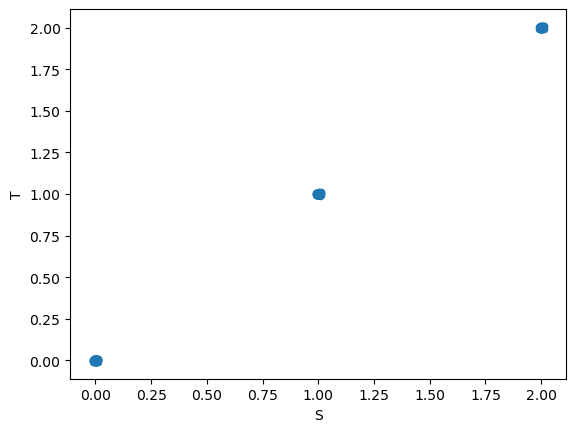

In [13]:
diags_ddf.compute().plot.scatter(x="S", y="T")

In [16]:
diags_ddf.where(diags_ddf.r == 1).T.mean().compute()

0.9997614392442051

In [19]:
diags_ddf.where(diags_ddf.r == 1).dropna().compute()

Task exception was never retrieved
future: <Task finished name='Task-92719' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2187> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2196, in wait
    raise AllExit()
distributed.client.AllExit


,S,T,t,r
1,1.001073,1.000047,0.0,1.0
1,0.995689,1.001083,1.0,1.0
1,1.001048,1.001185,2.0,1.0
1,0.996683,0.997000,3.0,1.0
1,0.994898,0.993897,5.0,1.0
...,...,...,...,...
1,1.003531,0.998766,356.0,1.0
1,1.002538,0.997019,357.0,1.0
1,1.001616,0.997365,358.0,1.0
1,0.992895,1.007479,359.0,1.0
